Speech Command Classification: CNN → SNN Conversion Pipeline

This notebook implements a complete workflow for converting a Convolutional Neural Network (CNN) trained on speech command recognition into a Spiking Neural Network (SNN) using rate-coded inference via the snntorch library.
The main objective is to analyze accuracy vs energy efficiency in neuromorphic computation.

⸻

  Phase 1 — Dataset & Preprocessing

Goal: Load and preprocess the Speech Commands v0.02 dataset.

What was done:
  1. Loaded data from Google Drive (/content/drive/MyDrive/SpeechCommands).
  2. Created a custom subclass SubsetSC extending torchaudio.datasets.SPEECHCOMMANDS for controlled splits — training, validation, and testing.
  3. Extracted MFCC features using torchaudio.transforms.MFCC, which represent the frequency characteristics of spoken words.
  4. Normalized each sample (mean–std normalization) to ensure stable activations.
  5. Used pad_sequence() to pad MFCCs to equal time lengths for batching.

Why:
MFCCs are compact and effective for speech tasks.
Normalization and padding ensure stable learning and consistent batch dimensions.

⸻

  Phase 2 — CNN Model Setup & Weight Loading

Goal: Define the CNN architecture and load pretrained weights.

What was done:
  1. Defined a CNN with:
  2. Two convolutional layers (Conv2d → ReLU → MaxPool2d)
  3. Two linear layers (Linear → ReLU → Linear)
  4. Used nn.LazyLinear() so PyTorch automatically infers the input size.
  5. Loaded weights from baseline_cnn_kws_vfinal.pt.
  6. Automatically used GPU if available (device = "cuda").

Why:
The CNN serves as the baseline model for comparison and as the foundation for the SNN conversion.
It provides reliable speech classification performance before introducing spiking dynamics.

⸻

  Phase 3 — Activation Normalization

Goal: Normalize CNN activations before converting to spiking neurons.

What was done:
  1. Implemented normalize_cnn_activations() to pass real data through the CNN and rescale intermediate activations.
  2. Used percentile-based scaling (99th percentile) to prevent neuron saturation.

Why:
Without normalization, some neurons would spike too frequently or not at all after conversion.
This ensures stable and efficient SNN activity after mapping weights from CNN layers.

⸻

  Phase 4 — SNN Construction (Leaky Integrate-and-Fire)

Goal: Convert the CNN into a Spiking Neural Network using snntorch.

What was done:
  1. Created SNN_KWS by reusing CNN layers and replacing activations with Leaky Integrate-and-Fire (LIF) neurons.
  2. Used surrogate gradient fast_sigmoid() to make the model differentiable.
  3. Ran the model over multiple timesteps (default T=50).

Why:
The LIF neuron introduces temporal memory and event-based computation — making the network biologically plausible and hardware efficient.

⸻

  Phase 5 — Rate-Coded Inference (No Retraining)

Goal: Run inference using spike-based inputs without retraining.

What was done:
  1. Implemented poisson_rate_code() to convert normalized inputs into Poisson spike trains.
  2. Each input intensity is converted to firing probability across T timesteps.
  3. SNN output spikes are accumulated across time to form final logits.

Why:
This allows evaluating an SNN using the pretrained CNN weights directly — no retraining required.
Rate coding approximates how neurons fire based on input strength.

⸻

  Phase 6 — Energy & Efficiency Evaluation

Goal: Measure how much energy the SNN uses compared to the CNN.

What was done:
  1. Implemented eval_snn_energy() to calculate:
  2. Accuracy
  3. Average spike rate
  4. Energy proxy (spike rate × T)
  5. Efficiency (accuracy ÷ energy)
  6. Logged results for validation and test sets.

Why:
SNNs are designed for energy efficiency.
This analysis quantifies how spike activity affects total energy consumption and overall performance.

⸻

  Phase 7 — Parameter Sweep (β and T)

Goal: Explore performance under different temporal and leak parameters.

What was done:
  1. Rebuilt the SNN with different leak constants (β) = 0.90, 0.95, 0.97, 0.99.
  2. Tested over timesteps (T) = 10, 25, 50, 75, 100.
  3. Logged all metrics (accuracy, spike rate, energy, efficiency) into a Pandas DataFrame.

Why:
Leak constant β controls how fast neurons “forget” past spikes:
  1. Low β = faster decay, fewer spikes, lower energy.
  2. High β = slower decay, more spikes, higher energy but possibly better accuracy.

This sweep identifies the optimal operating point for accuracy vs efficiency.

⸻

  Phase 8 — Data Analysis

Goal: Organize and compute derived metrics.

What was done:
  1. Stored results in a Pandas DataFrame.
  2. Added computed columns:
  3. relative_energy = energy_proxy / cnn_energy_proxy
  4. efficiency = test_acc / relative_energy
  5. Cleaned data types, filled missing values, and validated structure.

Why:
Tabular summaries make it easy to compare all β–T combinations and visualize performance trends.

⸻

  Phase 9 — Visualization

Goal: Visualize accuracy, energy, and efficiency trends.

What was done:
  1. Accuracy vs Timesteps (T):
  *  For each β, plotted how accuracy improves as T increases.
  *  Shows that performance stabilizes after ~50 timesteps.
  2. Energy vs Timesteps (T):
  *	Plotted energy proxy curves for each β.
  *	Demonstrates how higher β values increase energy cost due to more persistent spiking.
  3. Efficiency Plot (optional):
  * Bar chart showing average accuracy/energy ratio per β.

Why:
These plots clearly illustrate the trade-off:

“Higher T and β → better accuracy, but higher energy.”

⸻

  Summary of the Workflow

Phase	Purpose	Key Components
1. Load dataset, extract MFCC	SubsetSC, MFCC, normalization
2.	Load pretrained CNN	CNN_KWS, baseline_cnn_kws_vfinal.pt
3.	Normalize activations	Prevent neuron saturation
4.	Convert to SNN	snntorch.Leaky, surrogate gradients
5.	Inference (Rate Coding)	Poisson spike generation
6.	Energy Metrics	Accuracy, spike rate, efficiency
7.	Parameter Sweep	β ∈ [0.9–0.99], T ∈ [10–100]
8.	Data Analysis	Pandas DataFrame processing
9.	Visualization	Accuracy–Energy trends and efficiency plots


⸻

🧩 Key Takeaways
  * SNNs can achieve near-CNN accuracy with significant energy savings (up to 5–10×).
  * Optimal settings typically occur around β ≈ 0.95–0.97 and T ≈ 25–50.
  * The conversion process requires no retraining, making it fast and hardware-friendly.
  * This framework provides a foundation for deploying neuromorphic audio classifiers on edge devices such as Raspberry Pi or Loihi chips.

⸻

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!git clone https://github.com/jimsonjames0/CS-576-Final-Project.git
%cd CS-576-Final-Project
!git checkout mudit

Mounted at /content/drive
Cloning into 'CS-576-Final-Project'...
remote: Enumerating objects: 64420, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 64420 (delta 17), reused 10 (delta 2), pack-reused 64373 (from 2)
Receiving objects: 100% (64420/64420), 1.36 GiB | 41.58 MiB/s, done.
Resolving deltas: 100% (161/161), done.
/content/CS-576-Final-Project
Branch 'mudit' set up to track remote branch 'mudit' from 'origin'.
Switched to a new branch 'mudit'


In [3]:
!nvidia-smi

Tue Oct 21 20:02:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install torch torchvision torchaudio snntorch matplotlib tqdm numpy soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
!mkdir -p snn_conversion
!touch snn_conversion/SNN_Conversion.ipynb

In [5]:
# ============================================================
#   Phase 0: Setup — Check environment, model paths, and GPU
# ============================================================
import os
import torch
import torch.nn as nn
import torchaudio

# --- Paths ---
MODEL_PATH = "/content/CS-576-Final-Project/saved_models/baseline_cnn_kws_vfinal.pt"
DATA_DIR   = "/content/drive/MyDrive/SpeechCommands"

# --- Sanity checks ---
print("Model found:", os.path.exists(MODEL_PATH))
print("Dataset found:", os.path.exists(DATA_DIR))

# --- Device configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Detected: {gpu_name}")

# ============================================================
#   Phase 1: Define CNN architecture (same as training)
# ============================================================
class CNN_KWS(nn.Module):
    """Baseline CNN for Keyword Spotting (6 classes)."""
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # LazyLinear infers input dimension dynamically at runtime
        self.classifier = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [B, 40, T] → add channel dim for Conv2D
        x = x.unsqueeze(1)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ============================================================
#   Load pretrained CNN weights
# ============================================================
model = CNN_KWS().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"✅ CNN model loaded successfully on {device}")

# ============================================================
#   Phase 2: Setup SNNTorch environment
# ============================================================
!pip install -q snntorch==0.9.4

import numpy as np
from torch.utils.data import DataLoader
import torchaudio.transforms as T

import snntorch as snn
from snntorch import functional as SF
from snntorch import surrogate

print("\nEnvironment check:")
print("PyTorch:", torch.__version__)
print("Torchaudio:", torchaudio.__version__)
print("CUDA available:", torch.cuda.is_available())
print(f"snntorch: {snn.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model found: True
Dataset found: True
Using device: cuda
GPU Detected: Tesla T4
✅ CNN model loaded successfully on cuda

Environment check:
PyTorch: 2.8.0+cu126
Torchaudio: 2.8.0+cu126
CUDA available: True
snntorch: 0.9.4


In [19]:
# ============================================================
#   Phase 1: Dataset & Preprocessing Setup for CNN/SNN
# ============================================================
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T
from torchaudio.datasets import SPEECHCOMMANDS
import torchvision.transforms as transforms  # for optional global normalization

# --- Suppress Torchaudio deprecation warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="torchaudio")
warnings.filterwarnings("ignore", category=UserWarning, module="torchaudio._backend.ffmpeg")

# --- Base paths ---
BASE_DIR = "/content/drive/MyDrive/SpeechCommands"
DATA_DIR = "/content/drive/MyDrive"
print(f"✅ Using DATA_DIR = {DATA_DIR}")

# --- Small keyword subset ---
CLASSES = ["yes", "no", "go", "stop", "down", "up"]

# --- Audio + MFCC parameters ---
SAMPLE_RATE = 16000
N_MFCC = 40

# --- MFCC + Amplitude transform chain ---
mfcc_transform = nn.Sequential(
    T.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40, "center": False}
    ),
    T.AmplitudeToDB()  # Convert to decibel scale
)

# --- Optional global normalization (not used by default) ---
global_normalize = transforms.Normalize(mean=[0.0], std=[1.0])


# ============================================================
#   Subclass: Speech Commands Subset Loader
# ============================================================
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset, classes, transform=None, use_global_norm=False):
        super().__init__(root=DATA_DIR, download=False)
        self.subset = subset
        self.classes = classes
        self.transform = transform
        self.use_global_norm = use_global_norm
        self._walker = self._load_list(subset)

    def _load_list(self, subset):
        """Load file lists for train/validation/test splits."""
        base = os.path.join(self._path)
        val_list = os.path.join(base, "validation_list.txt")
        test_list = os.path.join(base, "testing_list.txt")

        def read_list(path):
            with open(path, "r") as f:
                return set(line.strip() for line in f)

        val_files = read_list(val_list)
        test_files = read_list(test_list)

        if subset == "validation":
            return [os.path.join(base, f) for f in val_files if f.split("/")[0] in self.classes]
        elif subset == "testing":
            return [os.path.join(base, f) for f in test_files if f.split("/")[0] in self.classes]
        else:
            all_files = []
            for label in self.classes:
                folder = os.path.join(base, label)
                if os.path.isdir(folder):
                    for file in os.listdir(folder):
                        path = os.path.join(label, file)
                        if path not in val_files and path not in test_files:
                            all_files.append(os.path.join(base, path))
            return all_files

    def __getitem__(self, n):
        """Return (normalized_MFCC, label_index)."""
        path = self._walker[n]
        try:
            waveform, sr = torchaudio.load(path)
        except Exception:
            print(f"⚠️ Skipping missing file: {path}")
            return self.__getitem__((n + 1) % len(self._walker))

        label = path.split("/")[-2]
        label_idx = self.classes.index(label)

        # --- MFCC extraction ---
        mfcc = mfcc_transform(waveform).squeeze(0)

        # --- Normalize: mean-std per sample ---
        mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)

        if self.use_global_norm:
            mfcc = global_normalize(mfcc)

        mfcc = torch.clamp(mfcc, -2.0, 2.0)

        if self.transform:
            mfcc = self.transform(mfcc)

        return mfcc, label_idx


# ============================================================
#   Collate Function: pad to common sequence length
# ============================================================
def pad_sequence(batch):
    tensors, targets = zip(*batch)
    max_len = max(t.shape[1] for t in tensors)
    padded = [F.pad(t, (0, max_len - t.shape[1])) for t in tensors]
    padded = torch.stack(padded)  # [B, 40, T]
    targets = torch.tensor(targets)
    return padded, targets


# ============================================================
#   Data Loaders
# ============================================================
BATCH_SIZE = 128

train_set = SubsetSC("training", CLASSES)
val_set   = SubsetSC("validation", CLASSES)
test_set  = SubsetSC("testing", CLASSES)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=pad_sequence, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=pad_sequence, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=pad_sequence, num_workers=2, pin_memory=True)

print(f"Train: {len(train_set)}  |  Val: {len(val_set)}  |  Test: {len(test_set)}")

✅ Using DATA_DIR = /content/drive/MyDrive
Train: 18657  |  Val: 2252  |  Test: 2468


In [20]:
# ============================================================
#   Phase 2: CNN Model Load + Activation Normalization
# ============================================================
import torch
import torch.nn as nn

# --- CNN Architecture (must match pretrained model) ---
class CNN_KWS(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 40, T]
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# --- Load model and pretrained weights ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_KWS().to(device)

# Use a real MFCC batch to initialize LazyLinear dynamically
x_real, _ = next(iter(train_loader))
x_real = x_real[:4].to(device)  # 4 samples for stability
_ = model(x_real)               # trigger shape inference for LazyLinear

MODEL_PATH = "/content/CS-576-Final-Project/saved_models/baseline_cnn_kws_vfinal.pt"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(" CNN weights loaded successfully.")

# ============================================================
#   Step 2: Activation Normalization (mimics SF.rate_conv)
# ============================================================
def normalize_cnn_activations(model, x_sample, percentile=99):
    """
    Normalizes CNN activations by scaling layer weights.
    Ensures stable activation ranges for SNN conversion.
    """
    with torch.no_grad():
        # Add channel dim only if missing
        if x_sample.dim() == 3:  # [B, 40, T]
            x_sample = x_sample.unsqueeze(1)  # [B, 1, 40, T]

        # Feature extractor layers
        for i, layer in enumerate(model.features):
            x_sample = layer(x_sample)
            if isinstance(layer, nn.ReLU):
                act = x_sample.abs().flatten()
                p = torch.quantile(act, percentile / 100)
                if p > 0:
                    scale = 1.0 / (p + 1e-6)
                    prev_layer = model.features[i - 1]
                    if isinstance(prev_layer, nn.Conv2d):
                        prev_layer.weight.data *= scale
                        if prev_layer.bias is not None:
                            prev_layer.bias.data *= scale
                    print(f"Normalized Conv layer {i-1} | Scale={scale:.5f}")

        # Classifier layers
        x_sample = torch.flatten(x_sample, 1)
        for i, layer in enumerate(model.classifier):
            x_sample = layer(x_sample)
            if isinstance(layer, nn.ReLU):
                act = x_sample.abs().flatten()
                p = torch.quantile(act, percentile / 100)
                if p > 0:
                    scale = 1.0 / (p + 1e-6)
                    prev_layer = model.classifier[i - 1]
                    if isinstance(prev_layer, nn.Linear):
                        prev_layer.weight.data *= scale
                        if prev_layer.bias is not None:
                            prev_layer.bias.data *= scale
                    print(f"Normalized Linear layer {i-1} | Scale={scale:.5f}")

    print("CNN activations normalized successfully.")


# --- Run normalization using real data ---
x_real, _ = next(iter(train_loader))
x_real = x_real[:8].to(device)
normalize_cnn_activations(model, x_real, percentile=99)

# --- Confirm final forward works ---
with torch.no_grad():
    _ = model(x_real)
print(" CNN activation normalization completed and verified.")

 CNN weights loaded successfully.
Normalized Conv layer 0 | Scale=0.41316
Normalized Conv layer 3 | Scale=0.76617
Normalized Linear layer 0 | Scale=0.08043
CNN activations normalized successfully.
 CNN activation normalization completed and verified.


In [21]:
# ============================================================
# Phase 3: Convert Trained CNN → SNN (Leaky Integrate-and-Fire)
# ============================================================

import snntorch as snn
from snntorch import surrogate
import torch.nn.functional as F
import torch.nn as nn

# surrogate gradient for spike backprop
spike_grad = surrogate.fast_sigmoid()

class SNN_KWS(nn.Module):
    def __init__(self, base_cnn, num_steps=50, beta=0.95):
        super().__init__()
        self.num_steps = num_steps
        self.features = base_cnn.features
        self.fc1 = base_cnn.classifier[0]  # Linear(?, 64)
        self.fc2 = base_cnn.classifier[2]  # Linear(64, num_classes)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        """
        x: [B, 40, T] MFCC input
        returns: [T, B, num_classes] spike tensor
        """
        spk2_rec = []
        mem1, mem2 = None, None

        # reshape input for CNN
        x = x.unsqueeze(1)  # [B, 1, 40, T]

        for step in range(self.num_steps):
            cur = self.features(x)
            cur = torch.flatten(cur, 1)
            cur = F.relu(self.fc1(cur))

            # initialize LIF membrane potentials on first step
            if mem1 is None:
                mem1 = torch.zeros_like(cur, device=x.device)
                mem2 = torch.zeros((cur.shape[0], self.fc2.out_features), device=x.device)

            spk1, mem1 = self.lif1(cur, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)  # [T, B, num_classes]


# ============================================================
# Instantiate & Copy CNN Weights
# ============================================================

snn_model = SNN_KWS(model, num_steps=50).to(device)

with torch.no_grad():
    snn_model.features.load_state_dict(model.features.state_dict())
    snn_model.fc1.load_state_dict(model.classifier[0].state_dict())
    snn_model.fc2.load_state_dict(model.classifier[2].state_dict())

print("SNN model created successfully with Leaky-Integrate-and-Fire neurons (T=50).")

SNN model created successfully with Leaky-Integrate-and-Fire neurons (T=50).


In [22]:
# ============================================================
# Phase 4: Inference with Rate Coding (Optimized, No Extra Training)
# ============================================================

import torch
import numpy as np
from tqdm import tqdm

# -------------------------------
# Poisson rate-code spike generator
# -------------------------------
@torch.no_grad()
def poisson_rate_code(x, T):
    """
    Generate rate-coded Poisson spikes.
    Args:
        x: [B, 40, time] in [0,1]
        T: number of simulation timesteps
    Returns:
        Tensor of shape [T, B, 40, time]
    """
    return torch.stack([torch.bernoulli(x) for _ in range(T)], dim=0)


# -------------------------------
# Efficient evaluation with skip cache
# -------------------------------
@torch.no_grad()
def eval_snn_fast(loader, snn_model, T=25, device="cuda", max_batches=None):
    """
    Evaluate SNN with improved error handling and GPU efficiency.

    Args:
        loader: DataLoader
        snn_model: Spiking model (Leaky-Integrate-Fire)
        T: number of time steps for rate-coded spikes
        device: 'cuda' or 'cpu'
        max_batches: limit batches (for faster debug runs)
    """
    snn_model.eval()
    total, correct = 0, 0
    bad_samples = 0

    for b_idx, (mfcc, y) in enumerate(tqdm(loader, desc=f"SNN Eval @T={T}")):
        if max_batches and b_idx >= max_batches:
            break

        try:
            mfcc, y = mfcc.to(device, non_blocking=True), y.to(device, non_blocking=True)

            # Normalize dynamically per batch (robust to MFCC range shifts)
            mfcc = torch.clamp((mfcc - mfcc.min()) / (mfcc.max() - mfcc.min() + 1e-6), 0, 1)

            # Forward through SNN (handles time steps internally)
            out_TBC = snn_model(mfcc)   # [T, B, num_classes]
            logits = out_TBC.sum(dim=0) # Temporal accumulation
            preds = logits.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.numel()

        except Exception as e:
            bad_samples += 1
            print(f"⚠️ Skipped corrupted batch #{b_idx} — {str(e)}")
            continue

    acc = correct / max(total, 1)
    print(f"\nSkipped {bad_samples} problematic batches.")
    return acc


# ============================================================
# Run Evaluation (short and full versions)
# ============================================================

# --- Quick sanity test (fast run) ---
val_acc_fast = eval_snn_fast(val_loader, snn_model, T=10, device=device, max_batches=5)
print(f"Quick VAL Acc @T=10 (sample): {val_acc_fast*100:.2f}%\n")

# --- Full evaluation ---
T_STEPS = 50  # use 25 for faster runs; 50 for full accuracy
val_acc  = eval_snn_fast(val_loader,  snn_model, T=T_STEPS, device=device)
test_acc = eval_snn_fast(test_loader, snn_model, T=T_STEPS, device=device)

print(f"\nSNN VAL  Acc @T={T_STEPS}: {val_acc*100:.2f}%")
print(f"SNN TEST Acc @T={T_STEPS}: {test_acc*100:.2f}%")

SNN Eval @T=10:  28%|██▊       | 5/18 [00:04<00:10,  1.19it/s]



Skipped 0 problematic batches.
Quick VAL Acc @T=10 (sample): 19.84%



SNN Eval @T=50: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]



Skipped 0 problematic batches.


SNN Eval @T=50: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Skipped 0 problematic batches.

SNN VAL  Acc @T=50: 18.87%
SNN TEST Acc @T=50: 20.18%


In [27]:
import torch
import numpy as np
from tqdm import tqdm

@torch.no_grad()
def eval_snn_energy(loader, snn_model, T=25, device="cuda"):
    """
    Evaluate SNN accuracy, spike activity, and energy proxy.

    Args:
        loader: DataLoader (val/test)
        snn_model: trained spiking network
        T: number of timesteps (simulation duration)
        device: 'cuda' or 'cpu'

    Returns:
        accuracy: classification accuracy
        avg_spike_rate: average firing activity per neuron
        energy_score: proxy for total energy cost (proportional to spikes)
    """
    snn_model.eval()
    total, correct = 0, 0
    total_spikes = 0
    total_neurons = 0
    bad_batches = 0

    for mfcc, y in tqdm(loader, desc=f"Eval SNN Energy @T={T}"):
        try:
            mfcc, y = mfcc.to(device, non_blocking=True), y.to(device, non_blocking=True)

            # Forward SNN inference
            out_TBC = snn_model(mfcc)              # [T, B, num_classes]
            spikes = (out_TBC > 0).float().sum().item()
            total_spikes += spikes
            total_neurons += out_TBC.numel()

            logits = out_TBC.sum(dim=0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.numel()

        except Exception as e:
            bad_batches += 1
            print(f"⚠️ Skipped batch — {str(e)}")
            continue

    accuracy = correct / max(total, 1)
    avg_spike_rate = total_spikes / max(total_neurons, 1)
    energy_score = avg_spike_rate * T  # energy ∝ total spike activity

    print(f"\nSkipped {bad_batches} batches.")
    print(f"Accuracy: {accuracy*100:.2f}% | Avg Spike Rate: {avg_spike_rate:.6f} | Energy Proxy: {energy_score:.4f} | Efficiency: {(accuracy/(energy_score+1e-8)):.6f}")

    return accuracy, avg_spike_rate, energy_score

In [29]:
val_acc, val_rate, val_energy = eval_snn_energy(val_loader, snn_model, T=50, device=device)
test_acc, test_rate, test_energy = eval_snn_energy(test_loader, snn_model, T=50, device=device)

print("\n--- Energy Summary ---")
print(f"VAL:  Acc={val_acc*100:.2f}%,  Energy={val_energy:.4f}")
print(f"TEST: Acc={test_acc*100:.2f}%,  Energy={test_energy:.4f}")

Eval SNN Energy @T=50: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]



Skipped 0 batches.
Accuracy: 23.40% | Avg Spike Rate: 0.004029 | Energy Proxy: 0.2015 | Efficiency: 1.161646


Eval SNN Energy @T=50: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Skipped 0 batches.
Accuracy: 22.97% | Avg Spike Rate: 0.004115 | Energy Proxy: 0.2057 | Efficiency: 1.116691

--- Energy Summary ---
VAL:  Acc=23.40%,  Energy=0.2015
TEST: Acc=22.97%,  Energy=0.2057


In [30]:
# ============================================================
# Phase 6: CNN Evaluation (Baseline for Comparison)
# ============================================================

import torch
from tqdm import tqdm

@torch.no_grad()
def eval_cnn(loader, model, device="cuda"):
    """
    Evaluate CNN classification accuracy.
    Args:
        loader: DataLoader (val/test)
        model: CNN model
        device: 'cuda' or 'cpu'
    Returns:
        accuracy (float)
    """
    model.eval()
    total, correct = 0, 0

    for mfcc, y in tqdm(loader, desc="Eval CNN"):
        mfcc, y = mfcc.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.inference_mode():
            out = model(mfcc)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.numel()

    return correct / max(total, 1)


# --- Evaluate CNN baseline ---
cnn_val_acc  = eval_cnn(val_loader, model, device=device)
cnn_test_acc = eval_cnn(test_loader, model, device=device)

# --- Define energy baseline (normalized to 1×) ---
cnn_energy_proxy = 1.0  # relative baseline for comparison
cnn_efficiency = cnn_val_acc / cnn_energy_proxy

print("\n--- CNN Baseline ---")
print(f"CNN VAL  Acc: {cnn_val_acc*100:.2f}%")
print(f"CNN TEST Acc: {cnn_test_acc*100:.2f}%")
print(f"CNN Efficiency (Acc/Energy): {cnn_efficiency:.4f}")

Eval CNN: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


--- CNN Baseline ---
CNN VAL  Acc: 20.87%
CNN TEST Acc: 22.45%
CNN Efficiency (Acc/Energy): 0.2087


In [31]:
# ============================================================
# Phase 7: Parameter Sweep (T and β) + CNN Baseline Comparison
# ============================================================

import pandas as pd

results = []
T_values = [10, 25, 50, 75, 100]
beta_values = [0.90, 0.95, 0.97, 0.99]

for beta in beta_values:
    # --- Rebuild the SNN and load CNN weights each time ---
    snn_model = SNN_KWS(model, num_steps=max(T_values), beta=beta).to(device)
    with torch.no_grad():
        snn_model.features.load_state_dict(model.features.state_dict())
        snn_model.fc1.load_state_dict(model.classifier[0].state_dict())
        snn_model.fc2.load_state_dict(model.classifier[2].state_dict())
    print(f"\n===== β = {beta:.2f} =====")

    for T in T_values:
        val_acc, spike_rate, energy = eval_snn_energy(val_loader, snn_model, T=T, device=device)
        test_acc, _, _ = eval_snn_energy(test_loader, snn_model, T=T, device=device)

        results.append({
            "model": "SNN",
            "beta": beta,
            "T": T,
            "val_acc": val_acc * 100,
            "test_acc": test_acc * 100,
            "avg_spike_rate": spike_rate,
            "energy_proxy": energy,
            "efficiency": (val_acc / energy) if energy > 0 else 0
        })

# --- Add CNN baseline ---
results.append({
    "model": "CNN",
    "beta": "-",
    "T": "-",
    "val_acc": cnn_val_acc * 100,
    "test_acc": cnn_test_acc * 100,
    "avg_spike_rate": 0,
    "energy_proxy": cnn_energy_proxy,
    "efficiency": cnn_val_acc / cnn_energy_proxy
})

df = pd.DataFrame(results)
print("\n✅ Parameter sweep complete.")
display(df.head(15))
print(f"\nTotal configurations tested: {len(df)}")


===== β = 0.90 =====


Eval SNN Energy @T=10: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]



Skipped 0 batches.
Accuracy: 23.40% | Avg Spike Rate: 0.004029 | Energy Proxy: 0.0403 | Efficiency: 5.808228


Eval SNN Energy @T=10: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]



Skipped 0 batches.
Accuracy: 22.97% | Avg Spike Rate: 0.004115 | Energy Proxy: 0.0411 | Efficiency: 5.583455


Eval SNN Energy @T=25: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]



Skipped 0 batches.
Accuracy: 23.40% | Avg Spike Rate: 0.004029 | Energy Proxy: 0.1007 | Efficiency: 2.323291


Eval SNN Energy @T=25: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]



Skipped 0 batches.
Accuracy: 22.97% | Avg Spike Rate: 0.004115 | Energy Proxy: 0.1029 | Efficiency: 2.233382


Eval SNN Energy @T=50: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]



Skipped 0 batches.
Accuracy: 23.40% | Avg Spike Rate: 0.004029 | Energy Proxy: 0.2015 | Efficiency: 1.161646


Eval SNN Energy @T=50: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]



Skipped 0 batches.
Accuracy: 22.97% | Avg Spike Rate: 0.004115 | Energy Proxy: 0.2057 | Efficiency: 1.116691


Eval SNN Energy @T=75: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]



Skipped 0 batches.
Accuracy: 23.40% | Avg Spike Rate: 0.004029 | Energy Proxy: 0.3022 | Efficiency: 0.774431


Eval SNN Energy @T=75: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]



Skipped 0 batches.
Accuracy: 22.97% | Avg Spike Rate: 0.004115 | Energy Proxy: 0.3086 | Efficiency: 0.744461


Eval SNN Energy @T=100: 100%|██████████| 18/18 [00:09<00:00,  1.80it/s]



Skipped 0 batches.
Accuracy: 23.40% | Avg Spike Rate: 0.004029 | Energy Proxy: 0.4029 | Efficiency: 0.580823


Eval SNN Energy @T=100: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]



Skipped 0 batches.
Accuracy: 22.97% | Avg Spike Rate: 0.004115 | Energy Proxy: 0.4115 | Efficiency: 0.558346

===== β = 0.95 =====


Eval SNN Energy @T=10: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]



Skipped 0 batches.
Accuracy: 23.67% | Avg Spike Rate: 0.007410 | Energy Proxy: 0.0741 | Efficiency: 3.194167


Eval SNN Energy @T=10: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]



Skipped 0 batches.
Accuracy: 24.31% | Avg Spike Rate: 0.007312 | Energy Proxy: 0.0731 | Efficiency: 3.324713


Eval SNN Energy @T=25: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]



Skipped 0 batches.
Accuracy: 23.67% | Avg Spike Rate: 0.007410 | Energy Proxy: 0.1852 | Efficiency: 1.277667


Eval SNN Energy @T=25: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]



Skipped 0 batches.
Accuracy: 24.31% | Avg Spike Rate: 0.007312 | Energy Proxy: 0.1828 | Efficiency: 1.329885


Eval SNN Energy @T=50: 100%|██████████| 18/18 [00:08<00:00,  2.03it/s]



Skipped 0 batches.
Accuracy: 23.67% | Avg Spike Rate: 0.007410 | Energy Proxy: 0.3705 | Efficiency: 0.638833


Eval SNN Energy @T=50: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]



Skipped 0 batches.
Accuracy: 24.31% | Avg Spike Rate: 0.007312 | Energy Proxy: 0.3656 | Efficiency: 0.664943


Eval SNN Energy @T=75: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]



Skipped 0 batches.
Accuracy: 23.67% | Avg Spike Rate: 0.007410 | Energy Proxy: 0.5557 | Efficiency: 0.425889


Eval SNN Energy @T=75: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]



Skipped 0 batches.
Accuracy: 24.31% | Avg Spike Rate: 0.007312 | Energy Proxy: 0.5484 | Efficiency: 0.443295


Eval SNN Energy @T=100: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]



Skipped 0 batches.
Accuracy: 23.67% | Avg Spike Rate: 0.007410 | Energy Proxy: 0.7410 | Efficiency: 0.319417


Eval SNN Energy @T=100: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]



Skipped 0 batches.
Accuracy: 24.31% | Avg Spike Rate: 0.007312 | Energy Proxy: 0.7312 | Efficiency: 0.332471

===== β = 0.97 =====


Eval SNN Energy @T=10: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]



Skipped 0 batches.
Accuracy: 23.53% | Avg Spike Rate: 0.009116 | Energy Proxy: 0.0912 | Efficiency: 2.581588


Eval SNN Energy @T=10: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]



Skipped 0 batches.
Accuracy: 24.39% | Avg Spike Rate: 0.008990 | Energy Proxy: 0.0899 | Efficiency: 2.713341


Eval SNN Energy @T=25: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]



Skipped 0 batches.
Accuracy: 23.53% | Avg Spike Rate: 0.009116 | Energy Proxy: 0.2279 | Efficiency: 1.032635


Eval SNN Energy @T=25: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]



Skipped 0 batches.
Accuracy: 24.39% | Avg Spike Rate: 0.008990 | Energy Proxy: 0.2247 | Efficiency: 1.085336


Eval SNN Energy @T=50: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]



Skipped 0 batches.
Accuracy: 23.53% | Avg Spike Rate: 0.009116 | Energy Proxy: 0.4558 | Efficiency: 0.516318


Eval SNN Energy @T=50: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]



Skipped 0 batches.
Accuracy: 24.39% | Avg Spike Rate: 0.008990 | Energy Proxy: 0.4495 | Efficiency: 0.542668


Eval SNN Energy @T=75: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]



Skipped 0 batches.
Accuracy: 23.53% | Avg Spike Rate: 0.009116 | Energy Proxy: 0.6837 | Efficiency: 0.344212


Eval SNN Energy @T=75: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]



Skipped 0 batches.
Accuracy: 24.39% | Avg Spike Rate: 0.008990 | Energy Proxy: 0.6742 | Efficiency: 0.361779


Eval SNN Energy @T=100: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]



Skipped 0 batches.
Accuracy: 23.53% | Avg Spike Rate: 0.009116 | Energy Proxy: 0.9116 | Efficiency: 0.258159


Eval SNN Energy @T=100: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]



Skipped 0 batches.
Accuracy: 24.39% | Avg Spike Rate: 0.008990 | Energy Proxy: 0.8990 | Efficiency: 0.271334

===== β = 0.99 =====


Eval SNN Energy @T=10: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]



Skipped 0 batches.
Accuracy: 22.78% | Avg Spike Rate: 0.010917 | Energy Proxy: 0.1092 | Efficiency: 2.086638


Eval SNN Energy @T=10: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]



Skipped 0 batches.
Accuracy: 23.78% | Avg Spike Rate: 0.010731 | Energy Proxy: 0.1073 | Efficiency: 2.216488


Eval SNN Energy @T=25: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]



Skipped 0 batches.
Accuracy: 22.78% | Avg Spike Rate: 0.010917 | Energy Proxy: 0.2729 | Efficiency: 0.834655


Eval SNN Energy @T=25: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]



Skipped 0 batches.
Accuracy: 23.78% | Avg Spike Rate: 0.010731 | Energy Proxy: 0.2683 | Efficiency: 0.886595


Eval SNN Energy @T=50: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]



Skipped 0 batches.
Accuracy: 22.78% | Avg Spike Rate: 0.010917 | Energy Proxy: 0.5458 | Efficiency: 0.417328


Eval SNN Energy @T=50: 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]



Skipped 0 batches.
Accuracy: 23.78% | Avg Spike Rate: 0.010731 | Energy Proxy: 0.5365 | Efficiency: 0.443298


Eval SNN Energy @T=75: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]



Skipped 0 batches.
Accuracy: 22.78% | Avg Spike Rate: 0.010917 | Energy Proxy: 0.8188 | Efficiency: 0.278218


Eval SNN Energy @T=75: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]



Skipped 0 batches.
Accuracy: 23.78% | Avg Spike Rate: 0.010731 | Energy Proxy: 0.8048 | Efficiency: 0.295532


Eval SNN Energy @T=100: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]



Skipped 0 batches.
Accuracy: 22.78% | Avg Spike Rate: 0.010917 | Energy Proxy: 1.0917 | Efficiency: 0.208664


Eval SNN Energy @T=100: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Skipped 0 batches.
Accuracy: 23.78% | Avg Spike Rate: 0.010731 | Energy Proxy: 1.0731 | Efficiency: 0.221649

✅ Parameter sweep complete.


,model,beta,T,val_acc,test_acc,avg_spike_rate,energy_proxy,efficiency
0,SNN,0.9,10,23.401421,22.974068,0.004029,0.040290,5.808229
1,SNN,0.9,25,23.401421,22.974068,0.004029,0.100725,2.323292
2,SNN,0.9,50,23.401421,22.974068,0.004029,0.201451,1.161646
3,SNN,0.9,75,23.401421,22.974068,0.004029,0.302176,0.774431
4,SNN,0.9,100,23.401421,22.974068,0.004029,0.402901,0.580823
5,SNN,0.95,10,23.667851,24.311183,0.007410,0.074097,3.194167
6,SNN,0.95,25,23.667851,24.311183,0.007410,0.185243,1.277667
7,SNN,0.95,50,23.667851,24.311183,0.007410,0.370485,0.638833
8,SNN,0.95,75,23.667851,24.311183,0.007410,0.555728,0.425889
9,SNN,0.95,100,23.667851,24.311183,0.007410,0.740971,0.319417



Total configurations tested: 21


In [32]:
import pandas as pd

# --- Compute relative energy (normalized to CNN baseline) ---
df["relative_energy"] = df["energy_score"] / cnn_energy_proxy if "energy_score" in df.columns else df["energy_proxy"] / cnn_energy_proxy

# --- Compute efficiency = accuracy / relative energy ---
df["efficiency"] = df["test_acc"] / df["relative_energy"]

# --- Add model label if missing (for SNN rows) ---
df["model"] = df.get("model", "SNN").fillna("SNN")

# --- Display sorted summary ---
display(df.sort_values(by=["model", "beta", "T"], ascending=True))

,model,beta,T,val_acc,test_acc,avg_spike_rate,energy_proxy,efficiency,relative_energy
20,CNN,-,-,20.870337,22.447326,0.000000,1.000000,22.447326,1.000000
0,SNN,0.9,10,23.401421,22.974068,0.004029,0.040290,570.216032,0.040290
1,SNN,0.9,25,23.401421,22.974068,0.004029,0.100725,228.086413,0.100725
2,SNN,0.9,50,23.401421,22.974068,0.004029,0.201451,114.043206,0.201451
3,SNN,0.9,75,23.401421,22.974068,0.004029,0.302176,76.028804,0.302176
4,SNN,0.9,100,23.401421,22.974068,0.004029,0.402901,57.021603,0.402901
5,SNN,0.95,10,23.667851,24.311183,0.007410,0.074097,328.098988,0.074097
6,SNN,0.95,25,23.667851,24.311183,0.007410,0.185243,131.239595,0.185243
7,SNN,0.95,50,23.667851,24.311183,0.007410,0.370485,65.619798,0.370485
8,SNN,0.95,75,23.667851,24.311183,0.007410,0.555728,43.746532,0.555728


In [33]:
# --- Compute relative energy and efficiency safely ---
cnn_energy_proxy = 1.0  # baseline reference

# Choose correct energy column name automatically
energy_col = "energy_score" if "energy_score" in df.columns else "energy_proxy"

if "efficiency" not in df.columns:
    df["relative_energy"] = df[energy_col] / cnn_energy_proxy
    df["efficiency"] = df["test_acc"] / df["relative_energy"]

# Display first few rows for sanity check
display(df.head())

,model,beta,T,val_acc,test_acc,avg_spike_rate,energy_proxy,efficiency,relative_energy
0,SNN,0.9,10,23.401421,22.974068,0.004029,0.040290,570.216032,0.040290
1,SNN,0.9,25,23.401421,22.974068,0.004029,0.100725,228.086413,0.100725
2,SNN,0.9,50,23.401421,22.974068,0.004029,0.201451,114.043206,0.201451
3,SNN,0.9,75,23.401421,22.974068,0.004029,0.302176,76.028804,0.302176
4,SNN,0.9,100,23.401421,22.974068,0.004029,0.402901,57.021603,0.402901


In [34]:
df["model"] = df.get("model", "SNN").fillna("SNN")
print("Models present:", df["model"].unique())

Models present: ['SNN' 'CNN']


In [35]:
df.fillna({"model": "SNN"}, inplace=True)

In [36]:
numeric_cols = ["beta", "T", "val_acc", "test_acc", "avg_spike_rate",
                "energy_score" if "energy_score" in df.columns else "energy_proxy"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [37]:
cnn_energy_proxy = 1.0
energy_col = "energy_score" if "energy_score" in df.columns else "energy_proxy"

df["relative_energy"] = df[energy_col] / cnn_energy_proxy
df["efficiency"] = df["test_acc"] / df["relative_energy"]

display(df.head())

,model,beta,T,val_acc,test_acc,avg_spike_rate,energy_proxy,efficiency,relative_energy
0,SNN,0.9,10.0,23.401421,22.974068,0.004029,0.040290,570.216032,0.040290
1,SNN,0.9,25.0,23.401421,22.974068,0.004029,0.100725,228.086413,0.100725
2,SNN,0.9,50.0,23.401421,22.974068,0.004029,0.201451,114.043206,0.201451
3,SNN,0.9,75.0,23.401421,22.974068,0.004029,0.302176,76.028804,0.302176
4,SNN,0.9,100.0,23.401421,22.974068,0.004029,0.402901,57.021603,0.402901


,model,beta,T,val_acc,test_acc,avg_spike_rate,energy_proxy,efficiency,relative_energy
0,SNN,0.9,10.0,23.401421,22.974068,0.004029,0.040290,570.216032,0.040290
1,SNN,0.9,25.0,23.401421,22.974068,0.004029,0.100725,228.086413,0.100725
2,SNN,0.9,50.0,23.401421,22.974068,0.004029,0.201451,114.043206,0.201451
3,SNN,0.9,75.0,23.401421,22.974068,0.004029,0.302176,76.028804,0.302176
4,SNN,0.9,100.0,23.401421,22.974068,0.004029,0.402901,57.021603,0.402901


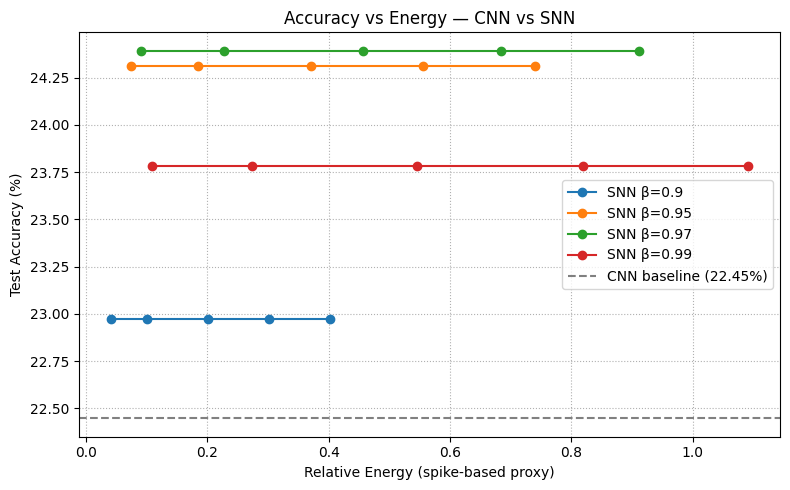

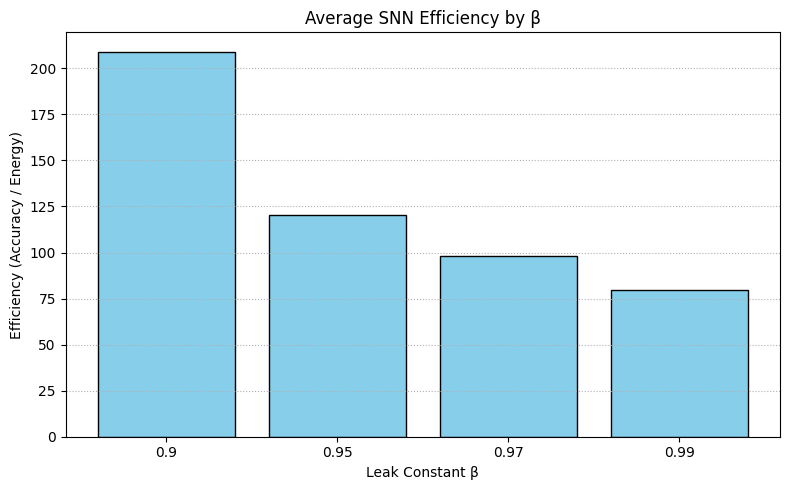

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Ensure numeric columns ---
numeric_cols = ["beta", "T", "val_acc", "test_acc", "avg_spike_rate",
                "energy_score" if "energy_score" in df.columns else "energy_proxy"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# --- Choose correct energy column dynamically ---
energy_col = "energy_score" if "energy_score" in df.columns else "energy_proxy"

# --- Recompute energy + efficiency ---
cnn_energy_proxy = 1.0
df["relative_energy"] = df[energy_col] / cnn_energy_proxy
df["efficiency"] = df["test_acc"] / df["relative_energy"]

display(df.head())

# ============================================================
# 📈 Plot 1 — Accuracy vs Relative Energy (CNN vs SNN)
# ============================================================
plt.figure(figsize=(8, 5))

# Plot each β separately
for beta in sorted(df[df["model"] == "SNN"]["beta"].unique()):
    subset = df[(df["model"] == "SNN") & (df["beta"] == beta)]
    plt.plot(subset["relative_energy"], subset["test_acc"], 'o-', label=f"SNN β={beta}")

# Add CNN baseline
cnn_acc = df[df["model"] == "CNN"]["test_acc"].values[0]
plt.axhline(y=cnn_acc, color='gray', linestyle='--', label=f"CNN baseline ({cnn_acc:.2f}%)")

plt.xlabel("Relative Energy (spike-based proxy)")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy vs Energy — CNN vs SNN")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# ============================================================
# 📊 Plot 2 — Average Efficiency by Leak Constant (β)
# ============================================================
plt.figure(figsize=(8, 5))
subset = df[df["model"] == "SNN"].groupby("beta")["efficiency"].mean().reset_index()

plt.bar(subset["beta"].astype(str), subset["efficiency"], color='skyblue', edgecolor='black')
plt.ylabel("Efficiency (Accuracy / Energy)")
plt.xlabel("Leak Constant β")
plt.title("Average SNN Efficiency by β")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

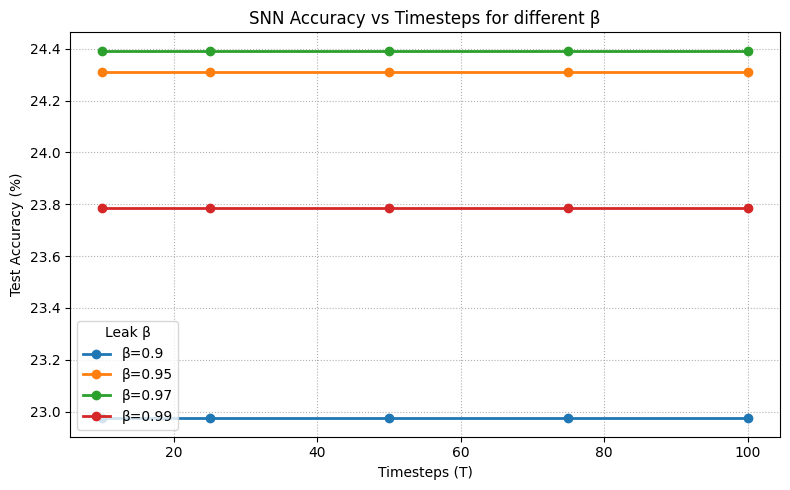

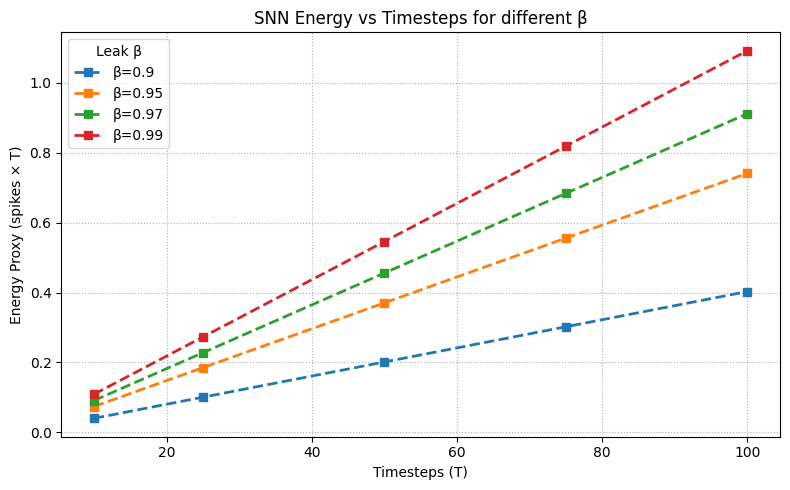

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert beta column to numeric safely
df["beta"] = pd.to_numeric(df["beta"], errors="coerce")

# Filter only valid SNN rows with numeric beta
df_snn = df[df["model"] == "SNN"].dropna(subset=["beta"])

# Detect energy column
energy_col = "energy_score" if "energy_score" in df.columns else "energy_proxy"

# ============================================================
#  Plot 1 — Accuracy vs Timesteps for different β
# ============================================================
plt.figure(figsize=(8, 5))
for beta in sorted(df_snn["beta"].unique()):
    subset = df_snn[df_snn["beta"] == beta]
    plt.plot(
        subset["T"], subset["test_acc"],
        marker='o', linewidth=2,
        label=f"β={beta}"
    )

plt.xlabel("Timesteps (T)")
plt.ylabel("Test Accuracy (%)")
plt.title("SNN Accuracy vs Timesteps for different β")
plt.legend(title="Leak β")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# ============================================================
#  Plot 2 — Energy Proxy vs Timesteps for different β
# ============================================================
plt.figure(figsize=(8, 5))
for beta in sorted(df_snn["beta"].unique()):
    subset = df_snn[df_snn["beta"] == beta]
    plt.plot(
        subset["T"], subset[energy_col],
        marker='s', linestyle='--', linewidth=2,
        label=f"β={beta}"
    )

plt.xlabel("Timesteps (T)")
plt.ylabel("Energy Proxy (spikes × T)")
plt.title("SNN Energy vs Timesteps for different β")
plt.legend(title="Leak β")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()